In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import simps
import re
import os
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, fftfreq, fftshift
import math
from scipy import stats
import csv
import sys


### Functions for calculating metrics

# Calculates overshoot distance. takes in dataframe representing segment of trial
def compute_osd(distance, time):
    # Calculate positive area under derivative
    dist_derivative = np.gradient(distance, time)
    return simps(np.maximum(np.nan_to_num(dist_derivative, nan=0), 0), time)

# Calculates power spectral density of signal
def compute_psd(signal, fs):

    # Compute the PSD of the filtered signal
    frequencies, psd = welch(signal, fs=fs)

    return frequencies, psd

# Calculates energy spectral density of signal (PSD scaled by signal duration)
def compute_esd(signal, fs):

    # Compute the PSD of the filtered signal
    frequencies, psd = welch(signal, fs=fs)

    # Compute ESD
    duration = len(signal) / fs
    esd = psd * duration    

    return frequencies, esd

# Trying different method of computing esd by just squaring magnitude of fft
def compute_fft(signal, fs):

    # Compute fft of signal
    signal = np.array(signal)
    signal_fft = fftshift(fft(signal))
    freq = fftshift(fftfreq(len(signal), 1.0 / fs))

    # # ESD is magnitued squared
#    esd = (np.abs(signal_fft))**2

    return freq, signal_fft

# Compute a "speed metric" that represents task completion time. Using average speed of motion
def compute_speed_metric(signal, time):
    return np.abs(signal[-1] - signal[0]) / (time[-1] - time[0])


### Helper functions
# high pass bidirectional filter
def high_butter(signal, fs, fc, order):

    nyquist_frequency = 0.5 * fs
    
    # Design the high-pass filter
    b, a = butter(order, fc / nyquist_frequency, btype='high')

    # Apply the high-pass filter to the signal
    return filtfilt(b, a, signal)

# transforming coordinates
def transform_2d_coordinate(point, new_x_axis, new_origin):
    # Convert inputs to NumPy arrays for easy computation
    point = np.array(point)
    new_x_axis = np.array(new_x_axis)
    new_origin = np.array(new_origin)

    # Compute the transformation matrix
    translated_point = point - new_origin
    old_x_axis = np.array([1, 0])  # Assuming the old x-axis is the standard unit vector
    rotation_angle = np.arctan2(new_x_axis[1], new_x_axis[0])
    rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],
                                [-np.sin(rotation_angle), np.cos(rotation_angle)]])

    # Apply the transformation to the point
    new_point = np.dot(rotation_matrix, translated_point)

    return new_point


# Function to add red border to maximum value in each row
def annotate_extrema(data, ax, extrema_type='max'):
    if extrema_type == 'max':
        extrema_index = np.nanargmax(data, axis=1)
        color = 'red'
    if extrema_type == 'min':
        extrema_index = np.nanargmin(data, axis=1)
        color = 'orange'
    for i, max_col in enumerate(extrema_index):
        ax.add_patch(plt.Rectangle((max_col, i), 1, 1, fill=False, edgecolor=color, lw=3))


### Plotting functions
def plot_all_heatmaps(metric_df, data_folder):
    # Create a 2x5 subplot for the heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(32, 12))
    username = data_folder.removeprefix('data_files/user_')
    fig.suptitle(f'Data for {username}')
    
    # Define a function to highlight the maximum value in each row
    def highlight_max(data):
        max_index = np.argmax(data, axis=1)
        for i, max_col in enumerate(max_index):
            data[i, max_col] = data[i, max_col]
        return data

    

    # Plot heatmap for effective width
    heatmap_width = metric_df.pivot(
        index='latency', columns='scale', values='effective_width')
    ax = sns.heatmap(heatmap_width, ax=axes[0, 0], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0, 0].set_title('Effective Width vs. Latency and Scale')
    annotate_extrema(heatmap_width.values, ax, extrema_type='min')

    # Plot heatmap for effective distance
    heatmap_distance = metric_df.pivot(
        index='latency', columns='scale', values='effective_distance')
    ax = sns.heatmap(heatmap_distance, ax=axes[0, 1], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0, 1].set_title('Effective Distance vs. Latency and Scale')
    annotate_extrema(heatmap_distance.values, ax)

    # Plot heatmap for index of difficulty
    heatmap_difficulty = metric_df.pivot(
        index='latency', columns='scale', values='effective_difficulty')
    ax = sns.heatmap(heatmap_difficulty, ax=axes[0, 2], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0, 2].set_title('Effective Index of Difficulty vs. Latency and Scale')
    annotate_extrema(heatmap_difficulty.values, ax)

    # Plot heatmap for average movement time
    heatmap_MT = metric_df.pivot(
        index='latency', columns='scale', values='avg_movement_time')
    ax = sns.heatmap(heatmap_MT, ax=axes[0, 3], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0, 3].set_title('Avg Movement Time vs. Latency and Scale')
    annotate_extrema(heatmap_MT.values, ax, extrema_type='min')

    # Plot the heatmap for throughput
    heatmap_throughput = metric_df.pivot(
        index='latency', columns='scale', values='throughput')
    ax = sns.heatmap(heatmap_throughput, ax=axes[0, 4], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0, 4].set_title('Throughput vs. Latency and Scale')
    annotate_extrema(heatmap_throughput.values, ax)

    # Plot heatmap for target error
    heatmap_deviation = metric_df.pivot(
        index='latency', columns='scale', values='avg_target_error')
    ax = sns.heatmap(heatmap_deviation, ax=axes[1, 0], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1, 0].set_title('Avg Target Error vs. Latency and Scale')
    annotate_extrema(heatmap_deviation.values, ax, extrema_type='min')

    heatmap_osd = metric_df.pivot(
        index='latency', columns='scale', values='avg_osd')
    ax = sns.heatmap(heatmap_osd, ax=axes[1, 1], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1, 1].set_title('Avg OSD vs. Latency and Scale')
    annotate_extrema(heatmap_osd.values, ax, extrema_type='min')

    # # Plot heatmap for error percentage
    # heatmap_error_rate = metric_df.pivot(
    #     index='latency', columns='scale', values='target_error_rate')
    # ax = sns.heatmap(heatmap_error_rate, ax=axes[1, 2], cmap="YlGnBu", annot=True, fmt='.3g')
    # axes[1, 2].set_title('Error Rate vs. Latency and Scale')
    # annotate_extrema(heatmap_error_rate.values, ax, extrema_type='min')

    # # Plot heatmap for translation efficiency
    # heatmap_efficiency = metric_df.pivot(
    #     index='latency', columns='scale', values='avg_translation_efficiency')
    # ax = sns.heatmap(heatmap_efficiency, ax=axes[1, 2], cmap="YlGnBu", annot=True, fmt='.3g')
    # axes[1, 2].set_title('Translation Effiency vs. Latency and Scale')
    # annotate_extrema(heatmap_efficiency.values, ax, extrema_type='max')

    # Plot heatmap for total error (target deviation + osd)
    metric_df['total_error'] = metric_df['avg_osd'] + metric_df['avg_target_error']
    heatmap_error = metric_df.pivot(
        index='latency', columns='scale', values='total_error')
    ax = sns.heatmap(heatmap_error, ax=axes[1, 3], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1, 3].set_title('Total Error vs. Latency and Scale')
    annotate_extrema(heatmap_error.values, ax, extrema_type='min')

    # Plot heatmap for combined performance (movement speed - total error)
    metric_df['combo'] = 10*metric_df['throughput'] - metric_df['total_error']
    heatmap_combo = metric_df.pivot(
        index='latency', columns='scale', values='combo')
    ax = sns.heatmap(heatmap_combo, ax=axes[1, 2], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1, 2].set_title('Combined Performance vs. Latency and Scale')
    annotate_extrema(heatmap_combo.values, ax, extrema_type='max')


    heatmap_clutches = metric_df.pivot(
        index='latency', columns='scale', values='num_clutches')
    ax = sns.heatmap(heatmap_clutches, ax=axes[1, 4], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1, 4].set_title('Number of Clutches vs. Latency and Scale')
    


    plt.tight_layout()
    plt.savefig(f"{data_folder}/heatmap_all_metrics_withcombo.png")

    plt.show()


def plot_key_heatmaps(metric_df, data_folder):
    # Create a 2x5 subplot for the heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))

    # Define a function to highlight the maximum value in each row
    def highlight_max(data):
        max_index = np.argmax(data, axis=1)
        for i, max_col in enumerate(max_index):
            data[i, max_col] = data[i, max_col]
        return data

    # Function to add red border to maximum value in each row
    def annotate_extrema(data, ax, extrema_type='max'):
        if extrema_type == 'max':
            extrema_index = np.argmax(data, axis=1)
            color = 'red'
        if extrema_type == 'min':
            extrema_index = np.argmin(data, axis=1)
            color = 'orange'
        for i, max_col in enumerate(extrema_index):
            ax.add_patch(plt.Rectangle((max_col, i), 1, 1, fill=False, edgecolor=color, lw=3))

    # Plot the heatmap for throughput
    heatmap_throughput = metric_df.pivot(
        index='latency', columns='scale', values='throughput')
    ax = sns.heatmap(heatmap_throughput, ax=axes[0], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[0].set_title('Throughput vs. Latency and Scale')
    annotate_extrema(heatmap_throughput.values, ax)

    # Plot heatmap for total error (target deviation + osd)
    metric_df['total_error'] = metric_df['avg_osd'] + metric_df['avg_target_error']
    heatmap_error = metric_df.pivot(
        index='latency', columns='scale', values='total_error')
    ax = sns.heatmap(heatmap_error, ax=axes[1], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[1].set_title('Total Error vs. Latency and Scale')
    annotate_extrema(heatmap_error.values, ax, extrema_type='min')

    # Plot heatmap for combined performance (movement speed - total error)
    metric_df['combo'] = 10*metric_df['throughput'] - metric_df['total_error']
    heatmap_combo = metric_df.pivot(
        index='latency', columns='scale', values='combo')
    ax = sns.heatmap(heatmap_combo, ax=axes[2], cmap="YlGnBu", annot=True, fmt='.3g')
    axes[2].set_title('Combined Performance vs. Latency and Scale')
    annotate_extrema(heatmap_combo.values, ax, extrema_type='max')

    # plt.title("User A")
    plt.tight_layout()
    plt.savefig(f"{data_folder}/heatmap_key_metrics.png")
    plt.show()


    
# Plot ID vs. MT and regression line for fitt's analysis
def plot_fitts_regression(metric_df):
    # Plot MT vs. IDe and calculate linear regression line
    x = metric_df['effective_difficulty']
    y = metric_df['avg_movement_time']
    
    # Plotting the data points
    plt.scatter(x, y, color='blue', label='Data Points')

    # Calculating the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Creating the regression line
    regression_line = [slope * i + intercept for i in x]

    # Plotting the regression line
    plt.plot(x, regression_line, color='red', label='Regression Line')

    # Displaying the slope and intercept values on the plot
    # axes[3].text(0.5, 7, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}', style='italic', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

    # Adding labels and title
    plt.xlabel('Effective Difficulty')
    plt.ylabel('Average Movement Time')
    plt.title('Average Movement Time vs. Effective Difficulty with Linear Regression')


if __name__ == "__main__":

    # List of CSV files to process
    user = input("enter user: ")
    data_folder = f"data_files/user_{user}"
    if not os.path.exists(data_folder):
        print("Data folder doesn't exist")
        sys.exit()
    pattern = r'l(\d+(?:\.\d+)?)s(\d+(?:\.\d+)?)\.csv'
    count = 0

    # main data frame for performance metrics across trials
    metric_data = []

    # Coefficients for error metric
    c1 = 1
    c2 = 1
    c3 = 1

    # cutoff frequency

    signals = []

    # Loop through each CSV file in data folder
    for filename in os.listdir(data_folder):
        # if count == 1:
        #     break

        file_path = os.path.join(data_folder, filename)        
        match = re.match(pattern, filename)
        #print(match)
        if match:

            count += 1
            #print(match.group(1), match.group(2))
            latency = float(match.group(1))
            scale = float(match.group(2))            
            df = pd.read_csv(file_path)
            target_df = pd.read_csv(f"{data_folder}/target_data_l{match.group(1)}s{match.group(2)}.csv")

            # Find the indices where "click" is True
            click_indices = df.index[df['click']]
            df_noclick = df[~df["click"]]

            if len(click_indices) != 10:
                print(f"Warning! Data for {latency} latency and {scale} scale has {len(click_indices)} clicks!")

            target_distances = []
            osd_metric_set = []
            esd_metric_set = []
            psd_metric_set = []
            esd_fft_metric_set = []
            speed_metric_set = []
            movement_distances = []
            movement_times = []
            movement_speeds = []
            target_errors = [] # deviations of select point to intended target point
            target_distances = []
            end_points = []
            osd_set = []
            t_eff_set = []

            # Calculate mean and standard deviation of sampling rate in motion data file
            dt = df_noclick["time"].diff()
            fs = 1.0 / dt
            fs_mean = np.mean(fs)
            fs_std = np.std(fs)
            #if fs_std > 5:
            # print(f"Warning! Sampling Rate mean is {fs_mean}, std is {fs_std}")


            # # # Generate figure for metrics
            # # fig, axes = plt.subplots(2, 4, figsize=(24, 12))

            # Split the data into segments using the click indices
            for i in range(len(click_indices)-1):
                
                # Segment data by clicks 
                start_idx = click_indices[i]
                end_idx = click_indices[i+1]
                segment = df.iloc[start_idx:end_idx]
                

                start_point = np.array([df['ins_x'][start_idx], df['ins_y'][start_idx]]) 
                end_point = np.array([df['ins_x'][end_idx], df['ins_y'][end_idx]])
                target_to = np.array([target_df['0'][i+1], target_df['1'][i+1]])
                target_from = np.array([target_df['0'][i], target_df['1'][i]])
                movement_axis = target_to - start_point # defined from motion start point to target center
                trans_end_point = transform_2d_coordinate(end_point, movement_axis, target_to) # transform end points to target frame
                target_distance_signal = np.linalg.norm(segment[['ins_x', 'ins_y']].values - target_to, axis=1)
                osd = compute_osd(target_distance_signal, np.array(segment['time']))
                travel_distance = sum(((segment['ins_x'].diff().fillna(0))**2 + (segment['ins_y'].diff().fillna(0))**2)**0.5)
                translation_efficiency = np.linalg.norm(movement_axis) / travel_distance
                
                osd_set.append(osd)
                end_points.append(trans_end_point)
                movement_distances.append(math.dist(start_point, end_point)) # Euclidean dist between start and end points
                movement_times.append(df['time'][end_idx] - df['time'][start_idx])
                movement_speeds.append(movement_distances[-1] / movement_times[-1])
                target_distances.append(math.dist(target_from, target_to))
                target_errors.append(math.dist(end_point, target_to))
                t_eff_set.append(translation_efficiency)

            total_osd = np.sum(osd_set)
            avg_osd = np.mean(osd_set)
            avg_movement_speed = np.mean(np.array(movement_distances) / np.array(movement_times))
            avg_target_error = np.mean(target_errors)
            total_target_error = np.sum(target_errors)
            target_error_rate = (sum(1 for error in target_errors if error > 20) / len(target_errors)) * 100
            effective_distance = np.mean(movement_distances)
            end_point_std = np.linalg.norm(np.std(np.array(end_points), axis=0)) # standard deviation of end point scatter
            effective_width = 4.133 * end_point_std
            effective_difficulty = math.log2((effective_distance / effective_width) + 1)
            # difficulty = math.log2((np.mean(target_distances) / 40) + 1)
            # print('Target Distance = ', np.mean(target_distances), 'Theoretical ID = ', difficulty)
            avg_movement_time = np.mean(movement_times)
            throughput = effective_difficulty / avg_movement_time
            avg_translation_efficiency = np.mean(t_eff_set)

            num_clutches = sum((df['clutch']) & (df['clutch'].shift(-1) == False))
            
            

            metric_data.append([latency, scale, effective_difficulty, avg_movement_time, throughput,
                                avg_target_error, avg_movement_speed, effective_width, effective_distance,
                                avg_osd, target_error_rate, avg_translation_efficiency, num_clutches])


metric_df = pd.DataFrame(metric_data, columns=['latency', 'scale', 'effective_difficulty', 'avg_movement_time',
                                                   'throughput', 'avg_target_error', 'avg_movement_speed',
                                                   'effective_width', 'effective_distance', 'avg_osd', 'target_error_rate',
                                                   'avg_translation_efficiency', 'num_clutches'])


# Compute overall stats
tp = (metric_df['throughput'].min(), metric_df['throughput'].max(), metric_df['throughput'].mean())
mt = (metric_df['avg_movement_time'].min(), metric_df['avg_movement_time'].max(), metric_df['avg_movement_time'].mean())
target_error = (metric_df['avg_target_error'].min(), metric_df['avg_target_error'].max(), metric_df['avg_target_error'].mean())
osd = (metric_df['avg_osd'].min(), metric_df['avg_osd'].max(), metric_df['avg_osd'].mean())


Saving stuff

In [3]:
metric_df.to_csv(f'{data_folder}/metric_df.csv')

with open(f"{data_folder}/sum_stats.csv", mode='w', newline='') as f:
	writer = csv.writer(f)
	writer.writerow(["Overall Summary Statistics", f"User: {user}"])
	writer.writerow(["Metric", "Min", "Max", "Mean"])
	writer.writerow(["Throughput"] + list(tp))
	writer.writerow(["Movement Time"] + list(mt))
	writer.writerow(["Target Error"] + list(target_error))
	writer.writerow(["OSD"] + list(osd))


Plotting

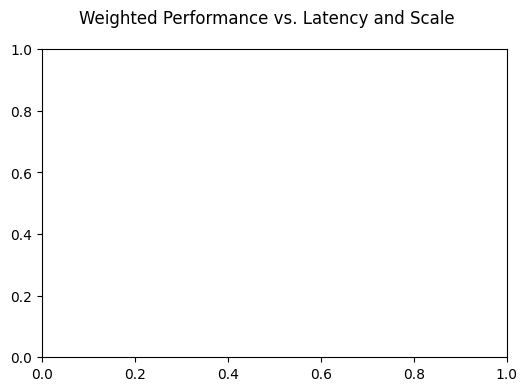

In [13]:
### Plotting weighted performance metric

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Assuming metric_df is defined and contains the necessary data

# Define the range for weights
w_min, w_max, step_size = 0.1, 5, 0.1
weights = np.arange(w_min, w_max + step_size, step_size)

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Weighted Performance vs. Latency and Scale")

# Animation update function
def update(weight):
    ax.clear()
    metric_df["performance"] = (10*metric_df["throughput"] - 
                                weight * (metric_df["avg_osd"] + metric_df["avg_target_error"]))
    heatmap = metric_df.pivot(index='latency', columns='scale', values='performance')
    sns.heatmap(heatmap, ax=ax, cmap="YlGnBu", annot=True, fmt='.3g')
    ax.set_title(f'w = {weight}')
    # annotate_extrema(heatmap.values, ax, extrema_type='max')

# Create the animation
ani = FuncAnimation(fig, update, frames=weights, repeat=False)

# Save the animation
# ani.save(f"weighted_performance_metric_animation.mp4", writer='ffmpeg', fps=10)

plt.show()


In [ ]:
### Animate weighted performance metric

fig, axes = plt.subplots(1, len(weights), figsize=(18, 4))
fig.suptitle("Weighted Performance vs. Latency and Scale")
for i, w in enumerate(weights):
	metric_df["performance"] = (10*metric_df["throughput"] - 
								w * (metric_df["avg_osd"] + metric_df["avg_target_error"]))
	
	# Plot heatmap
	heatmap = metric_df.pivot(
		index='latency', columns='scale', values='performance')
	ax = sns.heatmap(heatmap, ax=axes[i], cmap="YlGnBu", annot=True, fmt='.3g')
	axes[i].set_title(f'w = {w}')
	annotate_extrema(heatmap.values, ax, extrema_type='max')

plt.tight_layout()
plt.savefig(f"data_files/user_{user}/weighted_performance_metric.png", facecolor='w')
plt.show()

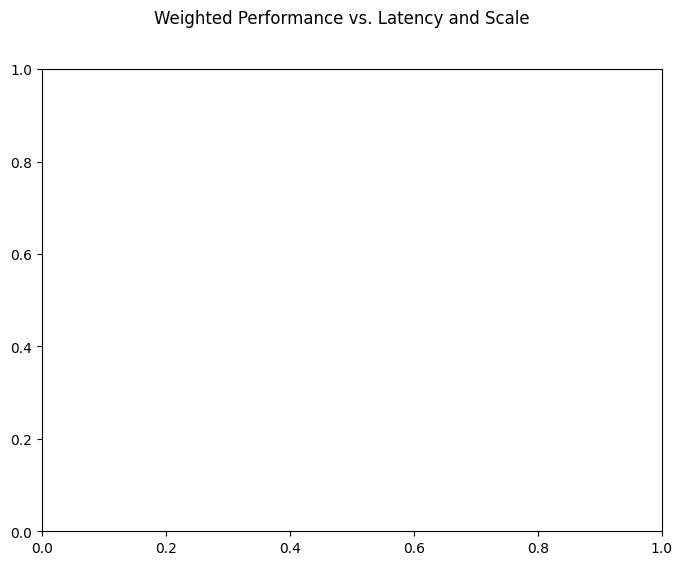

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Sample data preparation (replace this with your actual metric_df)
np.random.seed(0)
metric_df = pd.DataFrame({
    'throughput': np.random.rand(100),
    'avg_osd': np.random.rand(100),
    'avg_target_error': np.random.rand(100),
    'latency': np.random.choice(['Low', 'Medium', 'High'], 100),
    'scale': np.random.choice(['Small', 'Medium', 'Large'], 100)
})

# Define the range for weights
w_min, w_max, step_size = 0.1, 5, 0.1
weights = np.arange(w_min, w_max + step_size, step_size)

# Prepare the plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Weighted Performance vs. Latency and Scale")

# Update function for animation
def update(weight):
    ax.clear()
    metric_df["performance"] = (10 * metric_df["throughput"] - 
                                weight * (metric_df["avg_osd"] + metric_df["avg_target_error"]))
    heatmap = metric_df.pivot_table(index='latency', columns='scale', values='performance', aggfunc='mean')
    sns.heatmap(heatmap, ax=ax, cmap="YlGnBu", annot=True, fmt='.3g')
    ax.set_title(f'Weight = {weight:.2f}')

# Create the animation
ani = FuncAnimation(fig, update, frames=weights, repeat=False)

# Display the plot
plt.show()


In [5]:
df = metric_df
df.loc[df.groupby('latency')['performance'].idxmax()]

,latency,scale,effective_difficulty,avg_movement_time,throughput,avg_target_error,avg_movement_speed,effective_width,effective_distance,avg_osd,target_error_rate,avg_translation_efficiency,num_clutches,performance
4,0.00,0.400,3.719018,0.849119,4.379856,4.692530,222.634729,15.408224,187.494796,0.212882,0.000000,0.997016,0,33.987739
10,0.25,0.200,3.254216,2.050631,1.586934,5.973256,95.946233,22.123045,188.964010,0.933494,0.000000,0.983204,0,2.055842
17,0.50,0.200,2.673659,2.146172,1.245780,7.401030,96.524565,37.918902,204.020919,4.375823,11.111111,0.928161,0,-11.095903
21,0.75,0.075,2.705172,8.184226,0.330535,7.794748,25.475673,36.409553,201.030064,3.001622,0.000000,0.941697,11,-18.287390


In [12]:

optimal = df.loc[df.groupby('latency')['performance'].idxmax()][['latency', 'scale']]
filtered = optimal[optimal['latency'].isin([0.0, 0.5])]
optimal = optimal.sort_values('latency', ascending=False)
print(optimal['scale'])

21    0.075
17    0.200
10    0.200
4     0.400
Name: scale, dtype: float64


In [7]:
print(np.array(df['latency'].unique()))

[0.   0.25 0.5  0.75]


In [8]:
latency = [1, 2, 3, 4]
scale = [.1, .2, .3]
latency_grid, scale_grid = np.meshgrid(latency, scale)
print(latency_grid)
print(scale_grid)
np.column_stack([latency_grid.ravel(), scale_grid.ravel()])


[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
[[0.1 0.1 0.1 0.1]
 [0.2 0.2 0.2 0.2]
 [0.3 0.3 0.3 0.3]]


array([[1. , 0.1],
       [2. , 0.1],
       [3. , 0.1],
       [4. , 0.1],
       [1. , 0.2],
       [2. , 0.2],
       [3. , 0.2],
       [4. , 0.2],
       [1. , 0.3],
       [2. , 0.3],
       [3. , 0.3],
       [4. , 0.3]])